In [ ]:
!pip install facenet-pytorch
!pip install googledrivedownloader

# https://drive.google.com/file/d/1aRsW-68I5TUN4mctVrCdscByeOo_VaTm/view?usp=sharing
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1aRsW-68I5TUN4mctVrCdscByeOo_VaTm',
                                    dest_path='./data.zip',
                                    unzip=True)

     |████████████████████████████████| 1.9MB 4.0MB/s 
Unzipping...Done.


In [ ]:
# импортируем необходимые библиотеки

import os
import warnings
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from facenet_pytorch import (MTCNN, InceptionResnetV1,
                             fixed_image_standardization, training)
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm import tqdm_notebook as tqdm

warnings.filterwarnings('ignore')

np.random.seed(7)
sns.set()
sns.set_style("whitegrid", {'axes.grid': False})

# рабочие переменные
data = 'data/train_images'
train_test_split = 0.5
batch_size = 8
epochs = 30
workers = 1
learning_rate = 0.00007

# используем 'cpu'
device = torch.device('cpu')

# инициализируем модели MTCNN
mtcnn = MTCNN(image_size=160,
              margin=0,
              min_face_size=20,
              thresholds=[0.6, 0.7, 0.7],
              factor=0.709,
              post_process=True,
              device=device)

# детектирование лиц
dataset = datasets.ImageFolder(data, transform=transforms.Resize((512, 512)))
dataset.samples = [(p, p.replace(data, data + '_cropped'))
                   for p, _ in dataset.samples]

loader = DataLoader(dataset,
                    num_workers=workers,
                    batch_size=batch_size,
                    collate_fn=training.collate_pil)

print("детектирование лиц :")
for i, (x, y) in tqdm(enumerate(loader)):
    mtcnn(x, save_path=y)

# инициализируем модели RESNET
resnet = InceptionResnetV1(classify=True,
                           pretrained='vggface2',
                           dropout_prob=0.6,
                           num_classes=len(dataset.class_to_idx)).to(device)

# метод оптимизации, шаг обучения
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)
scheduler = MultiStepLR(optimizer=optimizer, milestones=[3, 5])

# трансформация входных данных, здесь можно аугментировать данные
trans = transforms.Compose(
    [np.float32,
     transforms.ToTensor(), fixed_image_standardization])

# вся обучающая выборка с детекстированными лицами
dataset = datasets.ImageFolder(data + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)

# разбиваем данные на обучающую и валидационную выборки
train_inds = img_inds[:int(train_test_split * len(img_inds))]
val_inds = img_inds[int(train_test_split * len(img_inds)):]

# обучающая и валидационная выборки
train_loader = DataLoader(dataset,
                          num_workers=workers,
                          batch_size=batch_size,
                          sampler=SubsetRandomSampler(train_inds))

val_loader = DataLoader(dataset,
                        num_workers=workers,
                        batch_size=batch_size,
                        sampler=SubsetRandomSampler(val_inds))

# функция потерь для задач мультиклассовой классификации
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {'acc': training.accuracy}

# Обучение
writer = SummaryWriter(f'runs/{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}')
writer.iteration, writer.interval = 0, 10

print("обучение :")
for epoch in tqdm(range(epochs)):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(resnet,
                        loss_fn,
                        train_loader,
                        optimizer,
                        scheduler,
                        batch_metrics=metrics,
                        show_running=True,
                        device=device,
                        writer=writer)

    resnet.eval()
    training.pass_epoch(resnet,
                        loss_fn,
                        val_loader,
                        batch_metrics=metrics,
                        show_running=True,
                        device=device,
                        writer=writer)

writer.close()

детектирование лиц :



обучение :



Epoch 1/30
----------
Train |     7/7    | loss:    2.4002 | acc:    0.2143   
Valid |     8/8    | loss:    1.8124 | acc:    0.7188   

Epoch 2/30
----------
Train |     7/7    | loss:    1.2070 | acc:    0.8571   
Valid |     8/8    | loss:    1.3131 | acc:    0.8906   

Epoch 3/30
----------
Train |     7/7    | loss:    0.7359 | acc:    1.0000   
Valid |     8/8    | loss:    1.0226 | acc:    0.9531   

Epoch 4/30
----------
Train |     7/7    | loss:    0.5671 | acc:    1.0000   
Valid |     8/8    | loss:    1.0719 | acc:    0.9375   

Epoch 5/30
----------
Train |     7/7    | loss:    0.6339 | acc:    0.9821   
Valid |     8/8    | loss:    0.9382 | acc:    0.9219   

Epoch 6/30
----------
Train |     7/7    | loss:    0.5343 | acc:    1.0000   
Valid |     8/8    | loss:    1.0610 | acc:    0.9219   

Epoch 7/30
----------
Train |     7/7    | loss:    0.5246 | acc:    1.0000   
Valid |     8/8    | loss:    1.1151 | acc:    0.8125   

Epoch 8/30
----------
Train |     7/7   

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir=runs --port 6006

Dataset ImageFolder
    Number of datapoints: 15
    Root location: data/test_images
Face detected with probability: 0.999996 alexandr_loukashenko ~ alexandr_loukashenko


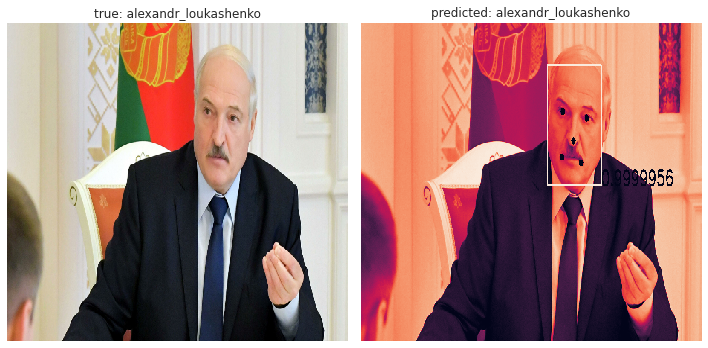

Face detected with probability: 0.999692 barack_obama ~ barack_obama


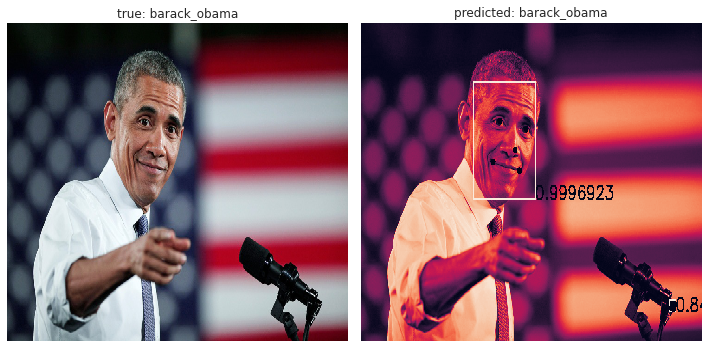

Face detected with probability: 0.999952 dmitrij_medvedev ~ dmitrij_medvedev


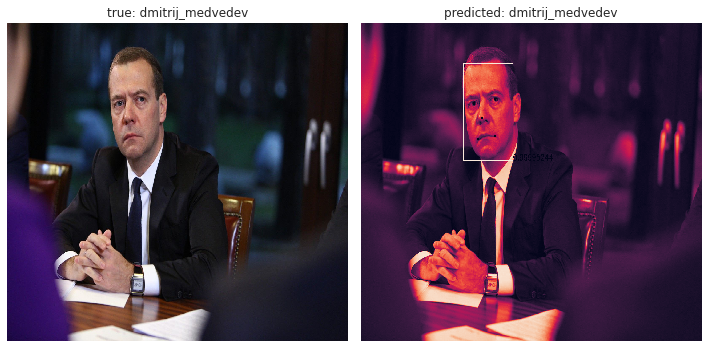

Face detected with probability: 0.999986 donald_trump ~ donald_trump


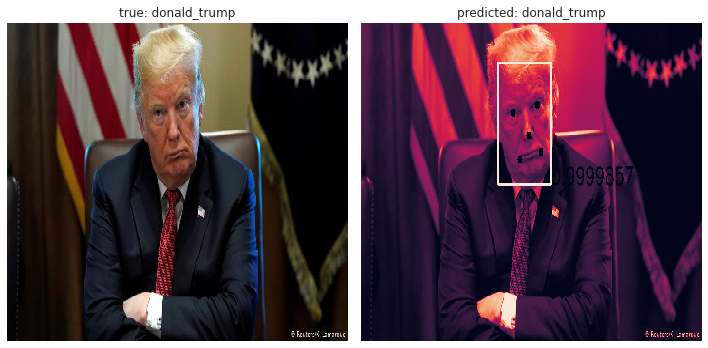

Face detected with probability: 1.000000 elvira_nabiullina ~ elvira_nabiullina


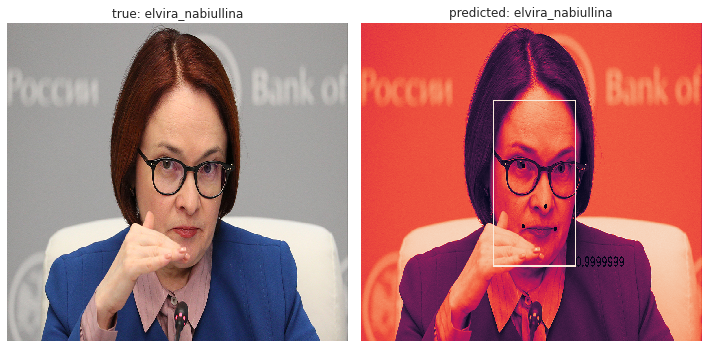

Face detected with probability: 0.999992 emmanuel_macron ~ emmanuel_macron


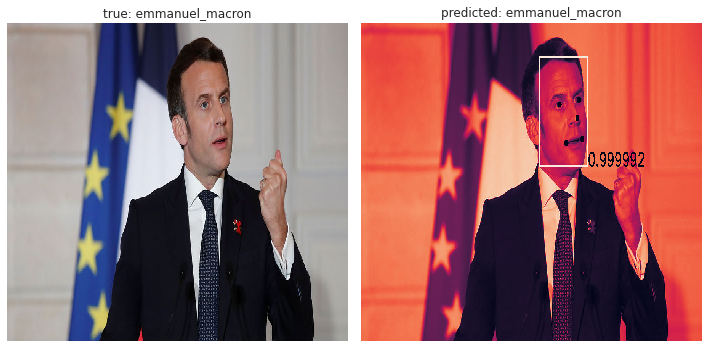

Face detected with probability: 0.999989 hassan_rouhani ~ hassan_rouhani


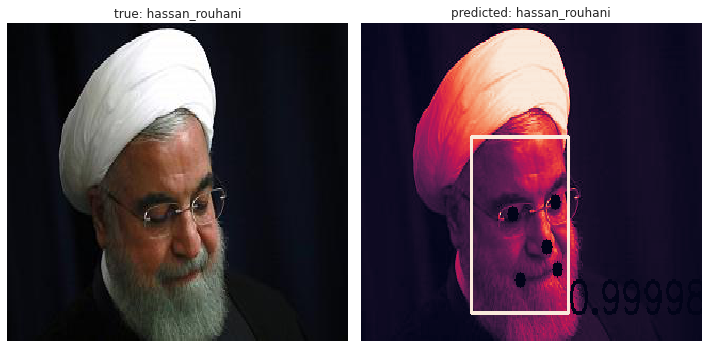

Face detected with probability: 0.998556 joe_biden ~ joe_biden


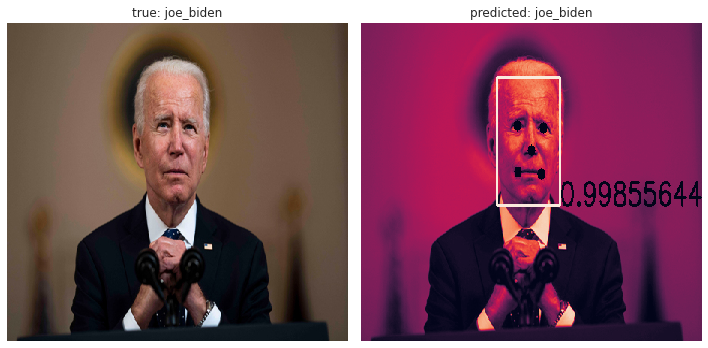

Face detected with probability: 0.997459 kamala_harris ~ kamala_harris


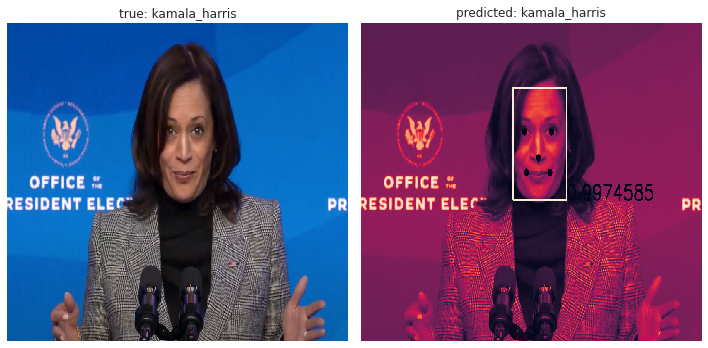

Face detected with probability: 0.999963 kersti_kaljulad ~ kersti_kaljulad


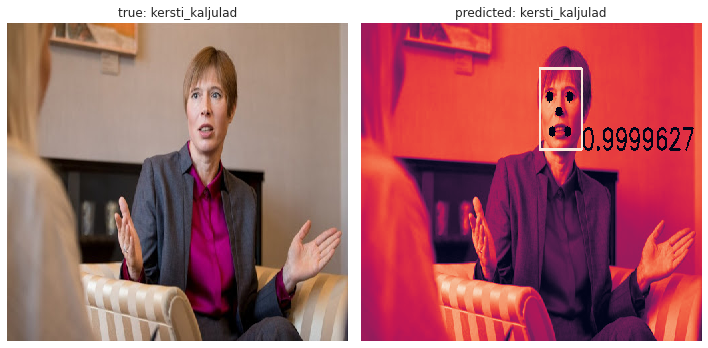

Face detected with probability: 0.999950 mikhail_mishustin ~ mikhail_mishustin


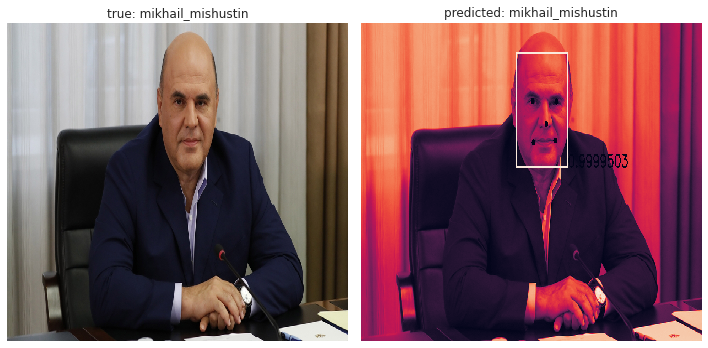

Face detected with probability: 0.999975 sergej_mironov ~ sergej_mironov


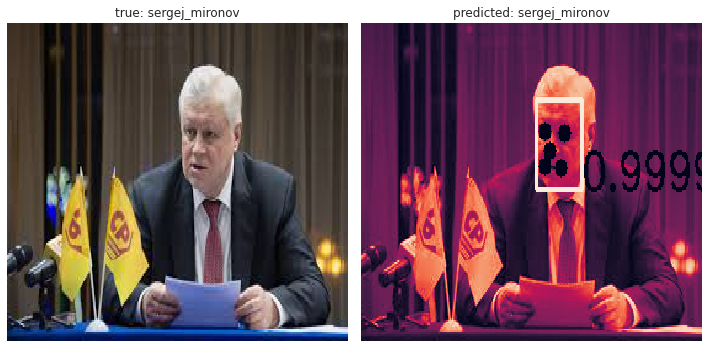

Face detected with probability: 0.999937 sergej_shoigu ~ sergej_shoigu


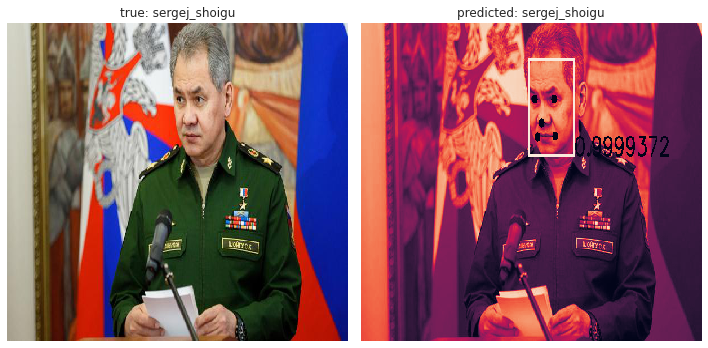

Face detected with probability: 0.999271 vladimir_putin ~ vladimir_putin


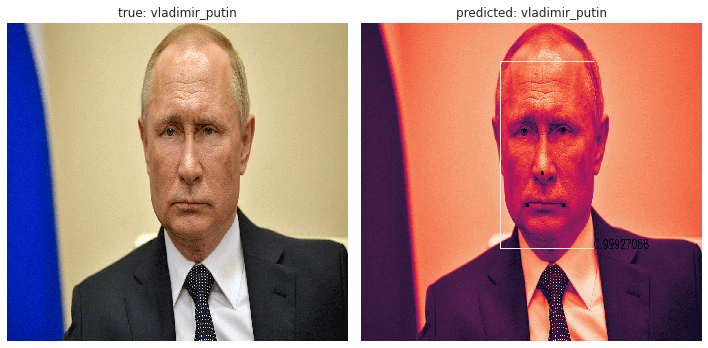

Face detected with probability: 0.999995 volodymyr_zelensky ~ volodymyr_zelensky


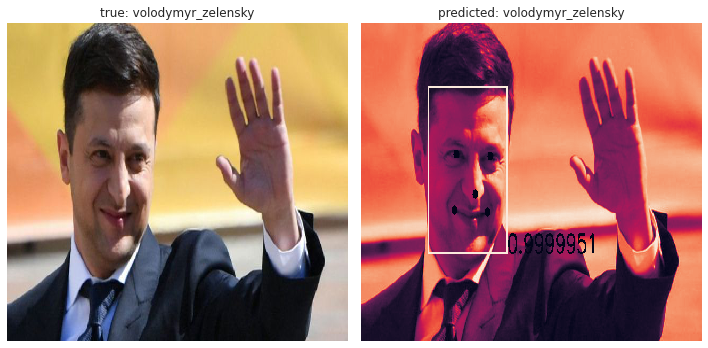

Качество классификации на тестовой выборке: 1.0


In [ ]:
# начинаем работать с тестовой выборкой
dataset = datasets.ImageFolder('data/test_images')
dataset.idx_to_class = {i: c for c, i in dataset.class_to_idx.items()}
print(dataset)


def collate_fn(x):
    return x[0]


loader2 = DataLoader(dataset, collate_fn=collate_fn, num_workers=0)

K, result = 0, 0

for x, y in loader2:
    # настоящий класс
    label_true = dataset.idx_to_class[y]

    # исходное изображение
    plt.figure(figsize=(10, 5))
    plt.subplot(121, aspect='equal', adjustable='box')
    plt.imshow(x, aspect='auto', interpolation='nearest')
    plt.axis('off')
    plt.title(f"true: {label_true}")

    # детектируем лицо
    img_cropped, prob = mtcnn(x, return_prob=True)
    img_embedding = resnet(img_cropped.unsqueeze(0))
    resnet.classify = True
    img_probs = resnet(img_cropped.unsqueeze(0))
    # предсказываем класс
    label_predicted = dataset.idx_to_class[np.argmax(
        img_probs.detach().numpy())]

    print('Face detected with probability: {:8f}'.format(prob), label_true,
          '~', label_predicted)

    x_gray = cv2.cvtColor(np.float32(x), cv2.COLOR_RGB2GRAY)
    # находим рамки
    boxes, probs, landmarks = mtcnn.detect(x, landmarks=True)
    for box, prob, ld in zip(boxes, probs, landmarks):

        # отмечаем участок детектированный как лицо
        cv2.rectangle(x_gray, (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])), (255, 255, 255),
                      thickness=2)

        cv2.putText(x_gray, str(prob), (box[2], box[3]),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

        cv2.circle(x_gray, tuple(ld[0]), 5, (0, 0, 255), -1)
        cv2.circle(x_gray, tuple(ld[1]), 5, (0, 0, 255), -1)
        cv2.circle(x_gray, tuple(ld[2]), 5, (0, 0, 255), -1)
        cv2.circle(x_gray, tuple(ld[3]), 5, (0, 0, 255), -1)
        cv2.circle(x_gray, tuple(ld[4]), 5, (0, 0, 255), -1)

    # итоговое изображение и предсказанный класс
    plt.subplot(122, aspect='equal', adjustable='box')
    plt.imshow(x_gray, aspect='auto', interpolation='nearest')
    plt.axis('off')
    plt.title(f"predicted: {label_predicted}")

    K += 1

    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'fig_test_{K}.png', dpi=300)
    plt.show()
    
    result += int(label_true == label_predicted)
    
print(f"Качество классификации на тестовой выборке: {result/K}")